# Billedeklassificering med Linear classifiers

I denne notebook arbejdes der med implementering og træning af lineære klassifikationsmodeller. Når I er færdige så skulle i gerne have fået indsigt i hvordan en parametrisk model er opbygget. Herunder hvordan loss/cost funktionen udregnes og hvordan gradienten af modellens parameter i forhold til dette bruges til at optimere modellen vha. af gradient decent.

Som i assignment1-1 er det tilladt at bruge ChatGPT, CO-Pilot etc. til at løse opgaven.

# Datasættet
Ligesom for kNN så anvendes der i denne notebook data fra "BloodMNIST" datasættet som kommer fra [MedMNIST databasen](https://medmnist.com/)

# Beskrivelse fra oprindelig kilde:
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.

Billederne er tilgængelige i forskellige opløsninger 28x28, 64x64, 128x128,og 224x224 med 3 kanaler (RGB). I denne notebook arbejder vi med billeder i opløsning 28x28x3. De 8 forskellige klasser er:

['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


Angivet kategorisk med værdierne:

[0, 1, 2, 3, 4, 5, 6, 7]

Nedenfor downloades og importeres datasættet og opdeles i separate trænings- og valideringssæt (tuning) og nogle eksempler illustreres.

In [210]:
%pip install medmnist
import medmnist

from medmnist import BloodMNIST
trainDataset = BloodMNIST(split="train", download=True,size=28)
valDataset = BloodMNIST(split="val", download=True,size=28)
testDataset = BloodMNIST(split="test", download=True,size=28)

Note: you may need to restart the kernel to use updated packages.
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz


Træningsdata:
Billeder: (11959, 28, 28, 3), Labels: (11959, 1)
Valideringsdata:
Billeder: (1712, 28, 28, 3), Labels: (1712, 1)
Testdata:
Billeder: (3421, 28, 28, 3), Labels: (3421, 1)


plot nogle eksempler:
klasse: 0, klassenavn: basophil. Antal træning samples: 852
klasse: 1, klassenavn: eosinophil. Antal træning samples: 2181
klasse: 2, klassenavn: erythroblast. Antal træning samples: 1085
klasse: 3, klassenavn: immature granulocytes(myelocytes, metamyelocytes and promyelocytes). Antal træning samples: 2026
klasse: 4, klassenavn: lymphocyte. Antal træning samples: 849
klasse: 5, klassenavn: monocyte. Antal træning samples: 993
klasse: 6, klassenavn: neutrophil. Antal træning samples: 2330
klasse: 7, klassenavn: platelet. Antal træning samples: 1643


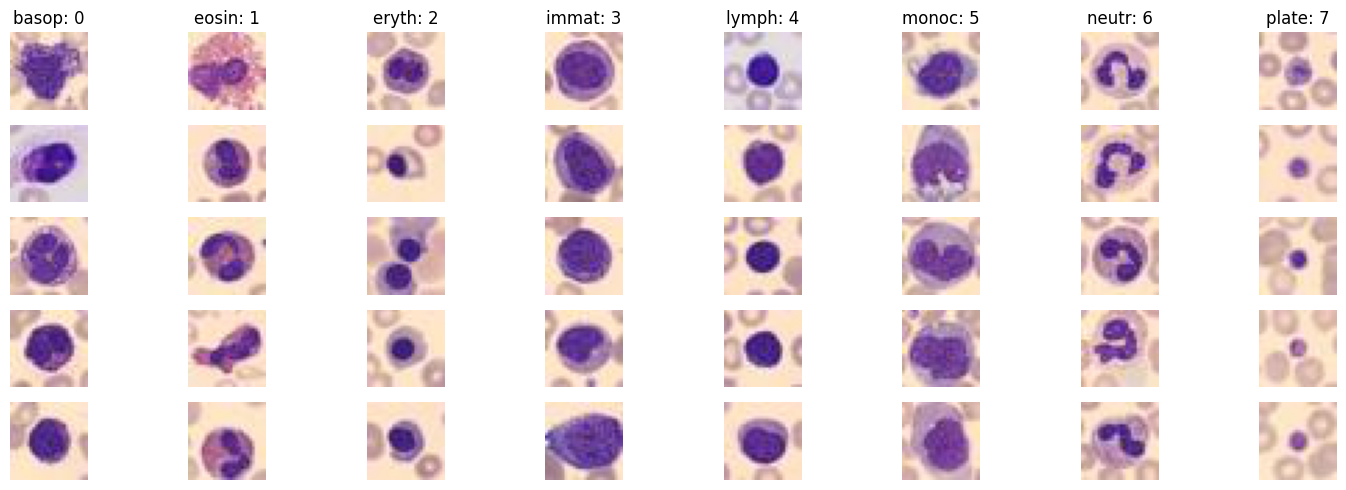

In [211]:
trainImages,trainLabels,trainInfo = trainDataset.__dict__['imgs'],trainDataset.__dict__['labels'],trainDataset.__dict__['info']['label']


print('Træningsdata:')
print(f'Billeder: {trainImages.shape}, Labels: {trainLabels.shape}')


valImages,valLabels = valDataset.__dict__['imgs'],valDataset.__dict__['labels']
print('Valideringsdata:')
print(f'Billeder: {valImages.shape}, Labels: {valLabels.shape}')

testImages,testLabels = testDataset.__dict__['imgs'],testDataset.__dict__['labels']
print('Testdata:')
print(f'Billeder: {testImages.shape}, Labels: {testLabels.shape}')

import matplotlib.pyplot as plt
import random

print('\n')
print('plot nogle eksempler:')

random.seed(42)
fig, axes = plt.subplots(5, len(trainInfo), figsize=(15, 5))

for class_,name in trainInfo.items():
    print(f'klasse: {class_}, klassenavn: {name}. Antal træning samples: {len(trainLabels[trainLabels==int(class_)])}')
    # Get indices of all images belonging to class i
    class_indices = [idx for idx, label in enumerate(trainLabels) if int(class_) == label]
    # Randomly select 5 indices
    selected_indices = random.sample(class_indices, 5)
    for j, idx in enumerate(selected_indices):
        image, label = trainImages[idx],trainLabels[idx]
        axes[j, int(class_)].imshow(image, cmap='gray')
        axes[j, int(class_)].axis('off')
        if j == 0:
            axes[j, int(class_)].set_title(f'{name[:5]}: {class_}')

plt.tight_layout()
plt.show()

In [212]:
import numpy as np

#set random seed for reproducibility
np.random.seed(0)

#Shuffle the data
randomize = np.arange(trainImages.shape[0])
np.random.shuffle(randomize)

X_train = trainImages[randomize]
y_train = trainLabels[randomize].flatten()

randomizeVal = np.arange(valImages.shape[0])
X_val = valImages[randomizeVal]
y_val = valLabels[randomizeVal].flatten()


# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))

X_train = X_train[mask]
y_train = y_train[mask]

print('first 10 examples in train: ',y_train[:10])

num_val = 500
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

print('first 10 examples in val: ',y_val[:10])

# Reshape the image data into rows for effecient distance calculation
#(vi tager billedet med dimensioner 28x28x3 og strækker det ud til en vektor med længden 28*28*3 = 2352)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(f'New train shape: {X_train.shape}')
print(f'New val shape: {X_val.shape}')


first 10 examples in train:  [1 0 2 7 7 4 3 0 4 7]
first 10 examples in val:  [4 0 7 6 1 6 1 7 6 5]
New train shape: (5000, 2352)
New val shape: (500, 2352)


[230.0064 199.1086 185.6402 230.0196 199.0904 185.7078 229.8808 199.2164
 185.9048 230.2784]


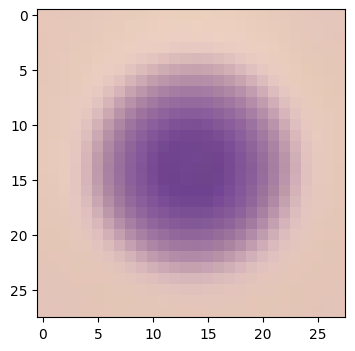

-194.6206 173.8098
(5000, 2353) (500, 2353)


In [213]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train = X_train.astype(np.float32)-mean_image
X_val = X_val.astype(np.float32)-mean_image

print(X_train.min(),X_train.max())

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

print(X_train.shape, X_val.shape)

## Standadizing data
You could consider standardizing you data, e.g divide by 255 to get it on a scale from [-1,1]. This may help to avoid exploding gradients since the current values of the input data are quite large.

In [214]:
# sandartizing the data
X_train /= 255
X_val /= 255

# Implementation of SVM/Hinge-loss
Below, implement a function to for calculating the hinge loss based on an image/set of images and associated class/label

In [215]:
#################################################
#generate a random SVM weight matrix of small
#numbers corresponding to image size (+ bias dimension)
#depth of num classes
##################################################
image_size = 28*28*3+1
num_classes = 8

W = np.random.randn(image_size, num_classes) * 0.0001

###################################################
#The function should accept The W weight-/parameter
#matrix along with an image/batch of images as input
#and return the loss for the
#image/batch based on the claculated scores
#The l2 regularization loss should also be included
#in the function's claculation.
#In order to check the implementation, try to claculate
#the loss but with, and without regularization.
#For the hinge/svm loss, the expected loss from random
#initialized wieghts ~= k-1 where k is number of classes
####################################################

def svm_loss(W,X,y,reg=0):

    loss = 0.0
    number_classes = W.shape[1]
    number_train = X.shape[0]
    
    gradient = np.zeros(W.shape)

    for i in range(number_train): # iterate batch
        scores = X[i].dot(W) # more efficient vectorized implementation instead of looping and calculating score for each class
        correct_class_score = scores[y[i]] # get the score of the correct class
        for j in range(number_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # 1 is delta
            if margin > 0: # instead of max(0,sj-sy+delta) because of gradient calculation
                loss += margin
                gradient[:,y[i]] -= X[i,:] 
                gradient[:,j] += X[i,:] 

    # Averaging over all examples
    loss /= number_train
    gradient /= number_train

    # Add regularization
    loss += 0.5 * reg * np.sum(W * W)
    gradient += reg*W # the gradient of the regularization term
    return loss, gradient 

# Test the loss using the validation set

E.g.:

    loss = svm_loss(W,X,y,reg):

In [216]:
#Test the loss with and without regularization using the validation set
#With regularization the loss should increase.
#test with large value. e.g. 1e3 to make sure

loss0, grad0 = svm_loss(W,X_val,y_val,reg=0)
loss1, grad1 = svm_loss(W,X_val,y_val,reg=1e3)

print('Loss without regularization: ',loss0)
print('Loss with regularization: ',loss1)
if (loss1 < loss0):
  print('Something is wrong it should increase')



number_classes = W.shape[1]
print('Number of classes: ',number_classes)
print(abs(loss0-(number_classes-1)))
if (abs(loss0-(number_classes-1)) < 0.4): # not sure about the tolerance. The difference is often below 0.7 but not always. 
  print('Implementation is correct') # hopefully
  




Loss without regularization:  6.999403010523917
Loss with regularization:  7.091711259115711
Number of classes:  8
0.0005969894760831096
Implementation is correct


# Compute the gradients of the weights with respect to the loss
In order to optimize the classifier we need to compute gradients for the weight matrix so the loss can be minimized. It is would be a good idea to include the gradient calculation in the loss function defined above such that scores, loss and gradient can be calculated at the same time using the function.

E.g.:

    loss,grad = svm_loss(W,X,y,reg)


The gradients are a matrix with the same shape a W. The regularization should also affect the gradient so make sure this is included in the computation




In [217]:
###################################################
#Once the implementation is complete try to print the
#shape of the gradient matrix as well as the first row
#It should return something similar to this:
# [-3.0962016  4.9891232 -4.0875872  0.8926112  1.0465696 -1.5291232
#  3.9497376 -2.1651296]
#####################################################

loss, gradient = svm_loss(W,X_val,y_val,reg=1e3)
print('Gradient shape: ',gradient.shape)
print(gradient[0])


Gradient shape:  (2353, 8)
[ 0.11467346  0.02611046  0.06742713 -0.1080647   0.08886996  0.01786056
 -0.0308696  -0.12306615]


# Implementation of Softmax-loss
Below, repeat the steps from above but for the softmax loss/gradient instead

In [218]:
def softmax_loss(W,X,y,reg=0):
  loss = 0.0
  number_classes = W.shape[1]
  number_train = X.shape[0]
  
  gradient = np.zeros(W.shape)

  for i in range(number_train): # iterate batch
      scores = X[i].dot(W) # get the scores

      e_sj = np.exp(scores) # e to the power of all scores
      sum_e = np.sum(e_sj) # sum of all e to the power of scores
      probabiliteis = e_sj/sum_e # probabilities for each class

      loss += -np.log(probabiliteis[y[i]]) # log loss for the correct class

      for j in range(number_classes):
          if j == y[i]:
              gradient[:,y[i]] -= X[i,:] * (1 - probabiliteis[j])
          else:
              gradient[:,j] += X[i,:] * probabiliteis[j]

      
  loss /= number_train
  loss += 0.5 * reg * np.sum(W * W) # L2 regularization 

  gradient /= number_train
  gradient += reg*W # the gradient of the regularization

  return loss, gradient


Test the loss and gradient calculations

E.g.:

    loss,grad = softmax_loss(W,X,y,reg)

The loss with an randomly initialized weight matrix should be ~ -ln(1/k) where k=number of classes

In [219]:
###################################################
#Once the implementation is complete try to print the
#loss, shape of the gradient matrix as well as the first row
#The gradient claculation should return something similar to this:
# [-0.36533844  0.69120216 -0.47791155  0.10853622  0.05629067 -0.23380291
#  0.50159745 -0.2805736 ]
#####################################################

loss, grad = softmax_loss(W,X_val,y_val,reg=0)
print('Loss: ',loss)
print('Gradient shape: ',grad.shape)
print(grad[0])

# with regularization
loss, grad = softmax_loss(W,X_val,y_val,reg=1e3)
print('Loss with regularization: ',loss)
print('Gradient shape with regularization: ',grad.shape)
print(grad[0])

# check if -ln(1/classes) is close to the loss
temp = -np.log(1/number_classes)
print('Difference between loss and -ln(1/classes): ',abs(loss-temp))
if (abs(loss-temp) < 0.09): 
  print('loss is approximate to -ln(1/classes)') # hopefully


Loss:  2.079367057248908
Gradient shape:  (2353, 8)
[-0.00151772  0.00244607 -0.00200357  0.00043681  0.00051355 -0.00074841
  0.00193474 -0.00106146]
Loss with regularization:  2.1716753058407017
Gradient shape with regularization:  (2353, 8)
[ 0.12529771  0.00899134  0.08145331 -0.11112833  0.08527931  0.02310872
 -0.04442403 -0.1156369 ]
Difference between loss and -ln(1/classes):  0.09223376416086593


# Implementation of linear classifier

The implementation of the linear classifier should be constructed as a class that initializes a weight matrix based on the shape of the input and number of classes and type of loss computed (SVM/Softmax). It should have methods for training (updating the weights) and inference (predicting classes from scores).

Note!

The training function should propably have a "batch_size" parameter such that training data is iterated in batches so as to not run out of memory. Use np.array_split to divide data into n batches of "batch_size".

psuedo code example:


    class LinearClassifier:
      def __init__(self, input_dim, num_classes, loss_type='softmax'):

          self.W = np.random.randn(input_dim, num_classes) * 0.01
          self.loss_type = loss_type

          method train()

          method softmax_loss()

          method svm_loss()

          method predict()

In [220]:

##################################
#Implement linear classifier class
##################################

class LinearClassifier():
    def __init__(self, input_dim, num_classes, softmax=False):
        self.W = np.random.randn(input_dim, num_classes) * 0.0001
        self.softmax = softmax
        self.history = []

    def svm_loss(self, X, y, reg=0):
        loss = 0.0
        number_classes = self.W.shape[1]
        number_train = X.shape[0]
        
        gradient = np.zeros(self.W.shape)

        for i in range(number_train): # iterate batch
            scores = X[i].dot(self.W) # more efficient vectorized implementation instead of looping and calculating score for each class
            correct_class_score = scores[y[i]] # get the score of the correct class
            for j in range(number_classes):
                if j == y[i]:
                    continue
                margin = scores[j] - correct_class_score + 1  # 1 is delta
                if margin > 0: # instead of max(0,sj-sy+delta) because of gradient calculation
                    loss += margin
                    gradient[:,y[i]] -= X[i,:] 
                    gradient[:,j] += X[i,:] 

        # Averaging over all examples
        loss /= number_train
        gradient /= number_train

        # Add regularization
        loss += 0.5 * reg * np.sum(self.W * self.W)
        gradient += reg*self.W # the gradient of the regularization term
        return loss, gradient 
    
    def get_weights(self):
        return self.W
        

    def softmax_loss(self, X, y, reg=0):
        loss = 0.0
        number_classes = self.W.shape[1]
        number_train = X.shape[0]
        
        gradient = np.zeros(self.W.shape)

        for i in range(number_train): # iterate batch
            scores = X[i].dot(self.W) # get the scores

            e_sj = np.exp(scores) # e to the power of all scores
            sum_e = np.sum(e_sj) # sum of all e to the power of scores
            probabiliteis = e_sj/sum_e # probabilities for each class

            loss += -np.log(probabiliteis[y[i]]) # log loss for the correct class

            for j in range(number_classes):
                if j == y[i]:
                    gradient[:,y[i]] -= X[i,:] * (1 - probabiliteis[j])
                else:
                    gradient[:,j] += X[i,:] * probabiliteis[j]

            
        loss /= number_train
        l2_reg = 0.5 * reg * np.sum(self.W * self.W) # L2 regularization 
        loss = loss + l2_reg

        gradient /= number_train
        gradient += reg*self.W # the gradient of the regularization

        return loss, gradient

    def loss(self, X, y, reg=0):
        if self.softmax:
            return self.softmax_loss(X,y,reg)
        else:
            return svm_loss(self.W,X,y,reg)

    def train(self, X, y, reg=0, batch_size=200, learning_rate=1e-3, number_steps=10, verbose=False):
        number_train = X.shape[0]

        for m in range(number_steps):
            batch_indices = np.random.choice(number_train, batch_size, replace=True)
            X_random = X[batch_indices]
            y_random = y[batch_indices]

            loss, gradient = self.loss(X_random, y_random, reg)
            self.history.append(loss)

            self.W -= learning_rate * gradient

            if verbose and m % 100 == 0:
                print(f'iteration {m}/{number_steps}: loss {loss}')
                
        return self.history


    def predict(self, X):
        scores = X.dot(self.W)
        predicted_label = np.argmax(scores, axis=1) # get the index of the highest score
        return predicted_label
    
    def print(self):
        print('Model: ',self.W)
        print('Softmax: ',self.softmax)
        return



# Train the classifier once on the training set
It might be a good idea to have the training function of you model return a "history" or similar object holding the values of the loss at each m steps of the training. Afterwards the history object (for instance a list) can be plottet to visualize how training progressed.

Calling the training function would thus look something like this:

    classifier = LinearClassifier(input_dim=28*28*3+1,num_classes=8, loss_type='svm')

    history = classifier.train(params)

    plot(history)

    #make predictions on the validation data
    pred = classifier.predict(X)

    #calculate the accuracy

SVM
Accuracy without regularization: 0.762
Accuracy with regularization: 0.772


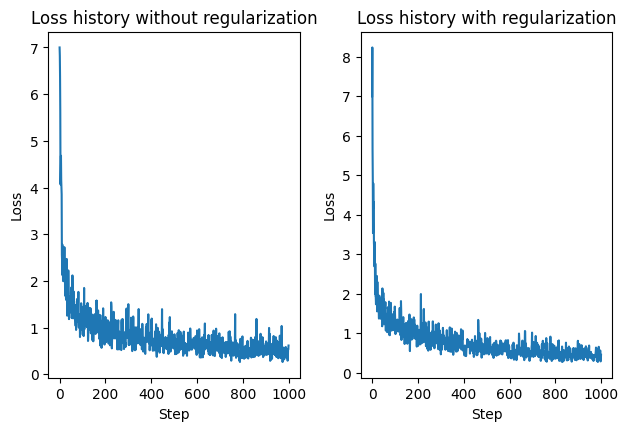

Softmax
Accuracy without regularization: 0.794
Accuracy with regularization: 0.814


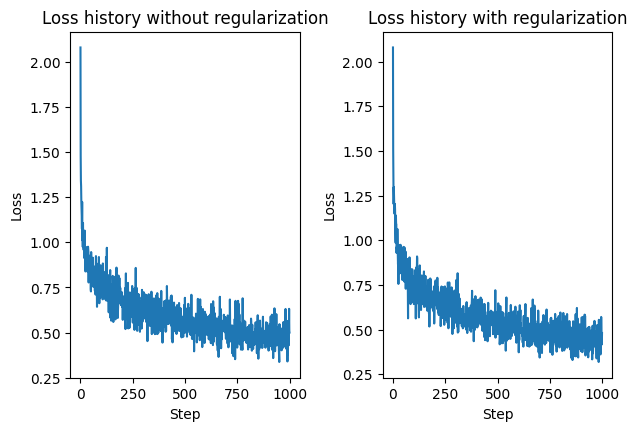

In [221]:
##########################################
#Train the classifier and plot the results
##########################################
# normalize traning data
#X_train = X_train / 255
import  matplotlib.pyplot as plt

# svm
print('SVM')
classifier = LinearClassifier(input_dim=28*28*3+1, num_classes=8, softmax=False)
history  = classifier.train(X_train, y_train, reg=0, batch_size=200, learning_rate=1 , number_steps=1000)
plt.subplot(1, 2, 1)
plt.plot(history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history without regularization')

predict = classifier.predict(X_val)
accuracy = np.mean(predict == y_val)
print(f'Accuracy without regularization: {accuracy}')


classifier = LinearClassifier(input_dim=28*28*3+1, num_classes=8, softmax=False)
history  = classifier.train(X_train, y_train, reg=-1e-4, batch_size=200, learning_rate=1, number_steps=1000)
plt.subplot(1, 2, 2)
plt.plot(history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history with regularization')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
predict = classifier.predict(X_val)
accuracy = np.mean(predict == y_val)
print(f'Accuracy with regularization: {accuracy}')


plt.show()




# softmax
print('Softmax')
classifier = LinearClassifier(input_dim=28*28*3+1, num_classes=8, softmax=True)
history  = classifier.train(X_train, y_train, reg=0, batch_size=200, learning_rate=1 , number_steps=1000)

predict = classifier.predict(X_val)
accuracy = np.mean(predict == y_val)
print(f'Accuracy without regularization: {accuracy}')

plt.subplot(1, 2, 1)
plt.plot(history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history without regularization')

classifier = LinearClassifier(input_dim=28*28*3+1, num_classes=8, softmax=True)
history  = classifier.train(X_train, y_train, reg=-1e-4, batch_size=200, learning_rate=1, number_steps=1000)

predict = classifier.predict(X_val)
accuracy = np.mean(predict == y_val)
print(f'Accuracy with regularization: {accuracy}')


plt.subplot(1, 2, 2)
plt.plot(history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history with regularization')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



There is a clear difference in the way the loss functions work. SVM loss measures how much the prediciton margins(model cofidence) deviates from the correct class.
Softmax loss measures how well the model assigns correct probabilties to the correct class in comparison to other classes. 

So while i can put up the plots beside each other and compare them it does not provide a clear picture of how well the models are performing.


# Optimize SVM classifier
We start by optimizing the the classifier with the svm loss function.

Using the training and validation sets run training loops with different setting for learning rate and regularization strength. For each setting, iterate over the training set n times updating the weight matrix based on the gradients and evaluate performance on the validation set every m iterations. Save the best classifier object in a variable "best_svm".


E.g.

    best_svm = None
    best_accuracy = 0

    # These values are only given as examples. In your own loop
    # you should test more in order to optimize the classifier

    learning_rates = [1e-2,1e-4,1e-6]
    regularization_strenghts = [1,1e-2,1e-1,1e2]

    num_iters = 1000
    batch_size = 200

    for lr in learning_rates:
      for reg in regularizations_strenghts:

        svm = LinearClassifier(input_dim=28*28*3+1,num_classes=8,loss_type='svm')

        svm.train(params)

        pred = svm.predict(X)

        #calculate accuracy

        
        if accuracy > best_accuracy:
          best_svm = svm
          best_accuracy = accuracy


! It may take a long time for the model to converge. Therefor, the hyperparameter search in this notebook could be used to identify a reasonable set of hyperparameters and then the model should be trained for longer using these. Using the full training dataset to maximize performance
        


In [222]:
###########################
#Put optimization code here
###########################

def smooth_curve(values, window_size=10):
    smoothed_values = np.convolve(values, np.ones(window_size) / window_size, mode='valid')
    return smoothed_values


def parameter_optimization(batch_size=200, number_steps=1000, softmax=False):
    best_accuracy_lr_reg = [0,0,0]
    learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5]
    regularization_strengths = [1,1e-1,1e-2,1e-3,1e-4,1e-5]

    training_history = {lr: [] for lr in learning_rates}

    for lr in learning_rates:
        for reg in regularization_strengths:
            classifier = LinearClassifier(input_dim=28*28*3+1, num_classes=8, softmax=softmax)
            history = classifier.train(X_train, y_train, reg=reg, batch_size=batch_size, learning_rate=lr , number_steps=number_steps)

            predict = classifier.predict(X_val)
            accuracy = np.mean(predict == y_val)
            print(f'Accuracy with lr: {lr}, reg: {reg} = {accuracy}')

            training_history[lr].append((reg,history))

            if accuracy > best_accuracy_lr_reg[0]:
                best_accuracy_lr_reg = [accuracy,lr,reg]
                best_classifier = classifier

    print(f'Best accuracy: {best_accuracy_lr_reg[0]} with lr: {best_accuracy_lr_reg[1]}, reg: {best_accuracy_lr_reg[2]}')


    number_plots = len(training_history)
    number_rows = int(np.ceil(number_plots/2))

    fig, axes = plt.subplots(number_rows, 2, figsize=(15, 4*number_rows))
    axes = axes.flatten()

    for i, (lr, reg_loss) in enumerate(training_history.items()):
        ax = axes[i]

        for reg, loss in reg_loss:
            smooted = smooth_curve(loss)
            ax.plot(smooted, label=f'reg: {reg}')
        ax.set_title(f'lr: {lr}')
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

    return best_classifier, best_accuracy_lr_reg





I could be a good idea to record as much informartion as possible from the optimization. E.g. loss as function of hyperparameters. This can be used for visualizing results of the tuning and included in the assignment 1 report.

#visualize the weights
Depending on how you implemented the classifier it is possible to visualize the learned weights. I the classifier is well optimized you may notice the sort of class templates encoded in the weight matrix.



Accuracy with lr: 0.1, reg: 1 = 0.608
Accuracy with lr: 0.1, reg: 0.1 = 0.698
Accuracy with lr: 0.1, reg: 0.01 = 0.776
Accuracy with lr: 0.1, reg: 0.001 = 0.782
Accuracy with lr: 0.1, reg: 0.0001 = 0.782
Accuracy with lr: 0.1, reg: 1e-05 = 0.778
Accuracy with lr: 0.01, reg: 1 = 0.642
Accuracy with lr: 0.01, reg: 0.1 = 0.708
Accuracy with lr: 0.01, reg: 0.01 = 0.734
Accuracy with lr: 0.01, reg: 0.001 = 0.742
Accuracy with lr: 0.01, reg: 0.0001 = 0.744
Accuracy with lr: 0.01, reg: 1e-05 = 0.73
Accuracy with lr: 0.001, reg: 1 = 0.634
Accuracy with lr: 0.001, reg: 0.1 = 0.64
Accuracy with lr: 0.001, reg: 0.01 = 0.642
Accuracy with lr: 0.001, reg: 0.001 = 0.64
Accuracy with lr: 0.001, reg: 0.0001 = 0.646
Accuracy with lr: 0.001, reg: 1e-05 = 0.648
Accuracy with lr: 0.0001, reg: 1 = 0.524
Accuracy with lr: 0.0001, reg: 0.1 = 0.53
Accuracy with lr: 0.0001, reg: 0.01 = 0.53
Accuracy with lr: 0.0001, reg: 0.001 = 0.532
Accuracy with lr: 0.0001, reg: 0.0001 = 0.522
Accuracy with lr: 0.0001, reg:

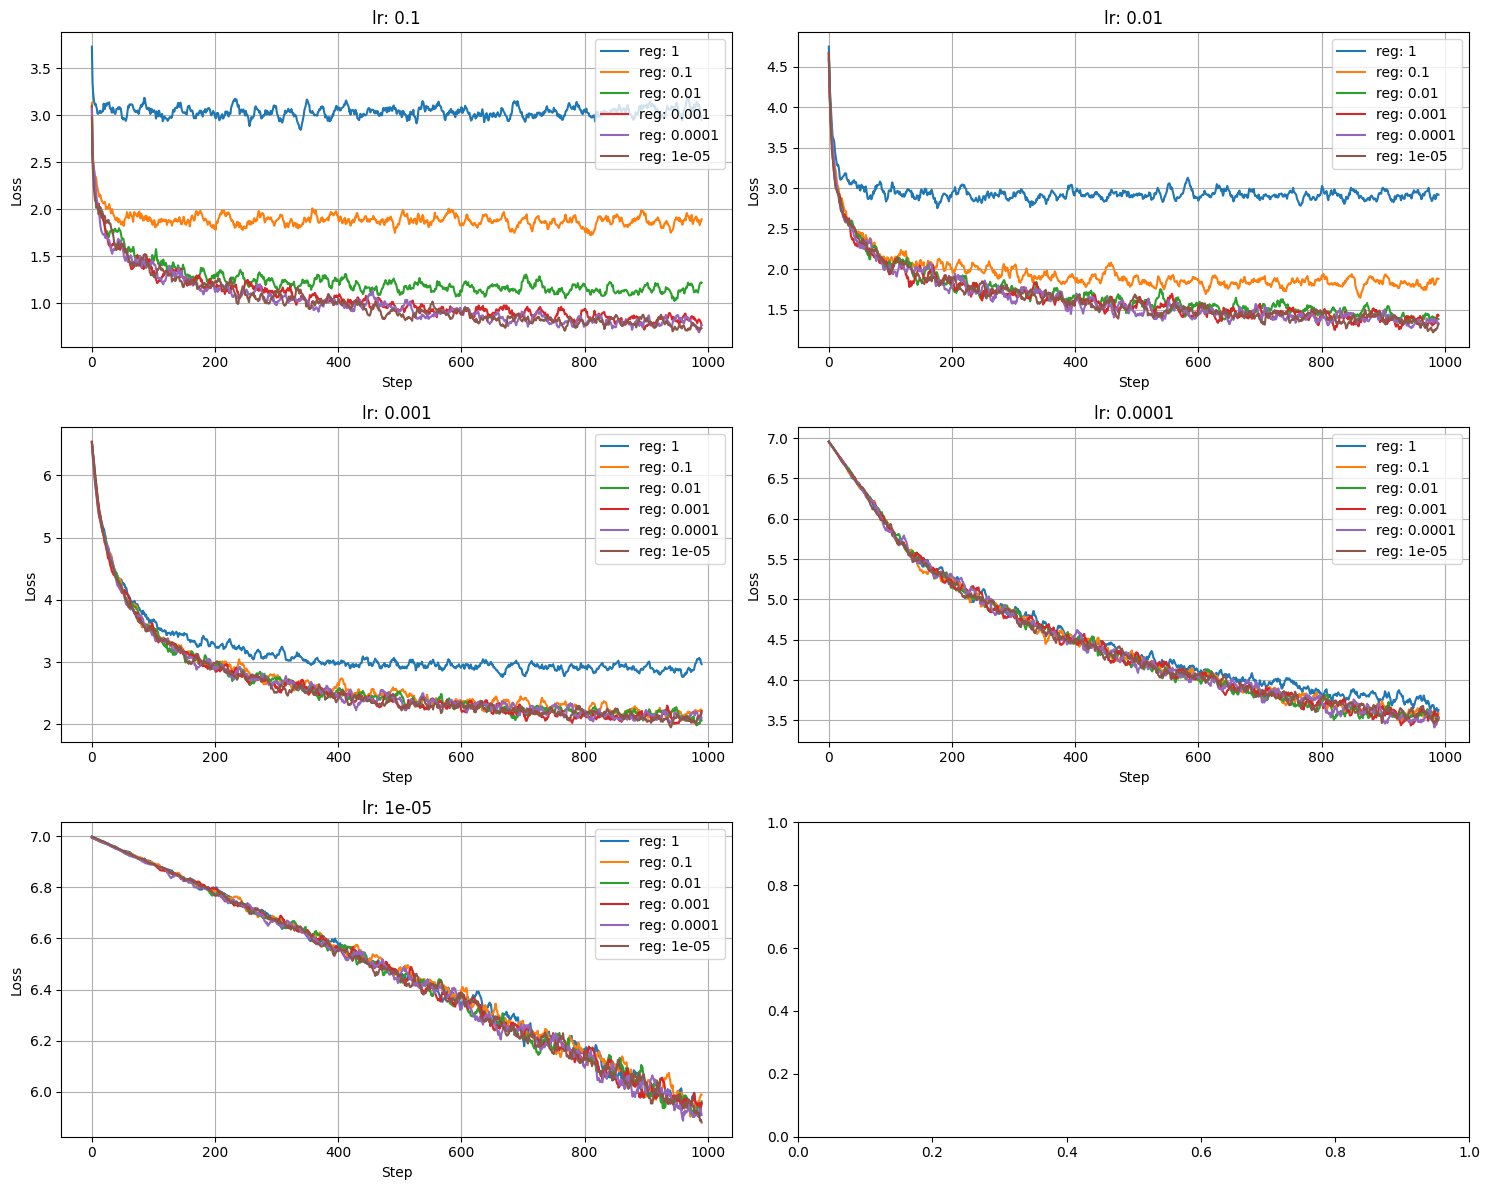

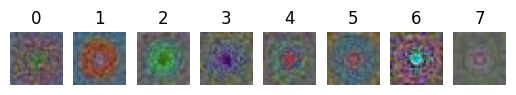

In [223]:
#Visualization of learned weights. This may or may not work depending on how your classifier is implemented.
best_classifier, best_accuracy_lr_reg = parameter_optimization(batch_size=200, number_steps=1000, softmax=False)

weights = best_classifier.get_weights()

w = weights[:-1,:] # strip out the bias
w = w.reshape(28, 28, 3, 8)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
for i in range(8):
    plt.subplot(1, 8, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])



You can compare the learned weights to a set of randomly initialized weights

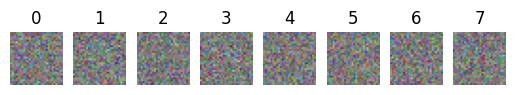

In [224]:
#Compare the trained weights to a set of random initialized weights
w = np.random.randn(28*28*3+1, num_classes) * 0.001
w = w[:-1,:] # strip out the bias
w = w.reshape(28, 28, 3, 8)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
for i in range(8):
    plt.subplot(1, 8, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# Optimize softmax classifier
Repeat the steps above but using the linear classifier with softmax loss. Report results for both in assignment 1

In the hand-in for assignment 1 you should be able to explain the implementation of the loss and gradients for the two types of linear classifiers. Therefore it might be good to include relevant code snippets.

The Hand in should include the tuning results/graphs (train and validation to discuss overfitting potential) and test set results think about metrics that make sense to calculate and include. E.g confusion matrix.

Accuracy with lr: 0.1, reg: 1 = 0.524
Accuracy with lr: 0.1, reg: 0.1 = 0.65
Accuracy with lr: 0.1, reg: 0.01 = 0.746
Accuracy with lr: 0.1, reg: 0.001 = 0.748
Accuracy with lr: 0.1, reg: 0.0001 = 0.752
Accuracy with lr: 0.1, reg: 1e-05 = 0.754
Accuracy with lr: 0.01, reg: 1 = 0.534
Accuracy with lr: 0.01, reg: 0.1 = 0.628
Accuracy with lr: 0.01, reg: 0.01 = 0.638
Accuracy with lr: 0.01, reg: 0.001 = 0.642
Accuracy with lr: 0.01, reg: 0.0001 = 0.64
Accuracy with lr: 0.01, reg: 1e-05 = 0.646
Accuracy with lr: 0.001, reg: 1 = 0.494
Accuracy with lr: 0.001, reg: 0.1 = 0.514
Accuracy with lr: 0.001, reg: 0.01 = 0.516
Accuracy with lr: 0.001, reg: 0.001 = 0.518
Accuracy with lr: 0.001, reg: 0.0001 = 0.518
Accuracy with lr: 0.001, reg: 1e-05 = 0.516
Accuracy with lr: 0.0001, reg: 1 = 0.464
Accuracy with lr: 0.0001, reg: 0.1 = 0.464
Accuracy with lr: 0.0001, reg: 0.01 = 0.46
Accuracy with lr: 0.0001, reg: 0.001 = 0.456
Accuracy with lr: 0.0001, reg: 0.0001 = 0.462
Accuracy with lr: 0.0001, re

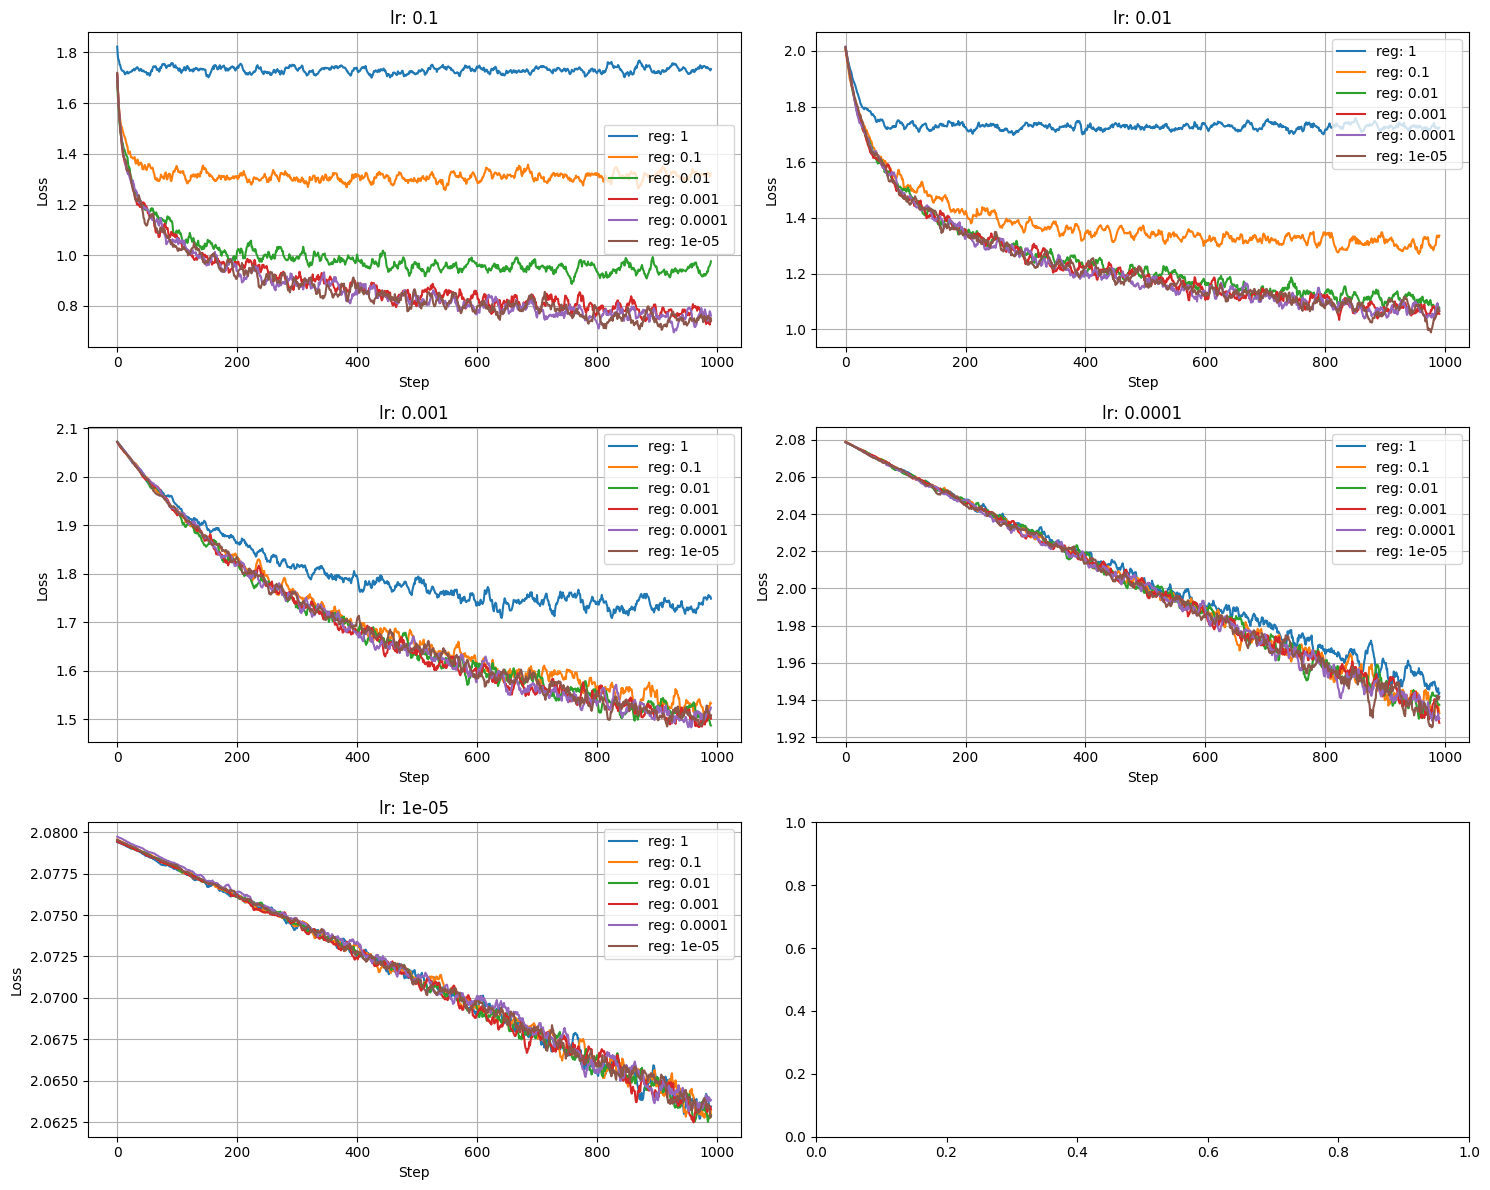

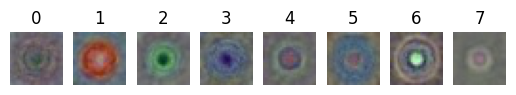

In [227]:
# softmax optimization
best_classifier, _ = parameter_optimization(batch_size=200, number_steps=1000, softmax=True)

weights = best_classifier.get_weights()

w = weights[:-1,:] # strip out the bias
w = w.reshape(28, 28, 3, 8)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
for i in range(8):
    plt.subplot(1, 8, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

